In [1]:

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Funciones

In [2]:
#Funcion para ver la cantidad de valores nulos por columna
def count_null_incol(df,col):
    null_values = df[col].isnull().sum()
    print(f"Total null values in column {col}: {null_values}")
    return null_values 

In [3]:

#This function merges the information of the different files into a single dataframe for every building
#When there is no information for a building in a file, the value is set to -1

def extract_data(building_id, df_name_list):
    df = pd.DataFrame()
    
    try:
        df['gas'] = df_name_list[0][building_id]
    except:
        df['gas'] = -1
        
    try:
        df['hotwater'] = df_name_list[1][building_id]
    except:
        df['hotwater'] = -1
        
    try:
        df['irrigation'] = df_name_list[2][building_id]
    except:
        df['irrigation'] = -1
        
    try:
        df['solar'] = df_name_list[3][building_id]
    except:
        df['solar'] = -1
        
    try:
        df['steam'] = df_name_list[4][building_id]
    except:
        df['steam'] = -1
        
    try:
        df['water'] = df_name_list[5][building_id]
    except:
        df['water'] = -1
        
    try:
        df['electricity'] = df_name_list[6][building_id]
    except:
        df['electricity'] = -1
        
    return df

In [4]:

#This function is used to merge the information of the weather with the data of the buildings   
def merge_weather(data, df_weather):
    df = data.merge(df_weather , left_index=True, right_index=True, how='left') 
    return df


def f_scaler(df):
    scalers = {}
    df_scaled = pd.DataFrame()
    for column in df.columns:
        scaler = MinMaxScaler()
        column_scaled = scaler.fit_transform(df[[column]])
        df_scaled[column] = column_scaled.flatten()
        scalers[column] = scaler
        
    return scalers, df_scaled

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def plot_predictions(y_test, y_pred, zoom_in=False, zoom_start=None, zoom_end=None):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title('Electricity Demand Prediction')
    plt.xlabel('Time (hours)')
    plt.ylabel('Electricity Demand (MW)')
    plt.legend()
    
    if zoom_in:
        plt.xlim(zoom_start, zoom_end)
    
    plt.show()

In [5]:
# Estudio de las variables de weather en site_id = 'Bobcat'

In [6]:
#Datos del Clima
 
df_weather = pd.read_csv('weather.csv')

df_weather_bobcat = df_weather[df_weather['site_id'] == 'Bobcat']

df_weather_bobcat.set_index('timestamp', inplace=True, drop=True)

df_weather_bobcat = df_weather_bobcat.drop(['site_id', 'precipDepth6HR'], axis=1)

df_weather_bobcat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17525 entries, 2016-01-01 00:00:00 to 2017-12-31 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   airTemperature  17494 non-null  float64
 1   cloudCoverage   12595 non-null  float64
 2   dewTemperature  17491 non-null  float64
 3   precipDepth1HR  17483 non-null  float64
 4   seaLvlPressure  17274 non-null  float64
 5   windDirection   16475 non-null  float64
 6   windSpeed       17379 non-null  float64
dtypes: float64(7)
memory usage: 1.1+ MB


In [7]:
#This dataframe has missing information that is not desplayed as nulls but as rows that dont exist at all and must be considered for the time series so we will create an empty dataframe with
# all the timestamps and then merge it with the weather dataframe to fill the missing values
start_date = '2016-01-01 00:00:00'
end_date = '2017-12-31 23:00:00'
interval = '1H'

index = pd.date_range(start=start_date, end=end_date, freq=interval)
df_time = pd.DataFrame(index=index)

df_time.index = pd.to_datetime(df_time.index)
df_weather_bobcat.index = pd.to_datetime(df_weather_bobcat.index)

merged_df = df_time.merge(df_weather_bobcat , left_index=True, right_index=True, how='left')

df_weather_bobcat = merged_df.copy()

null_values = []
for col in df_weather_bobcat.columns:    
    null_values.append(count_null_incol(df_weather_bobcat, col))

Total null values in column airTemperature: 50
Total null values in column cloudCoverage: 4949
Total null values in column dewTemperature: 53
Total null values in column precipDepth1HR: 61
Total null values in column seaLvlPressure: 270
Total null values in column windDirection: 1069
Total null values in column windSpeed: 165


Total null values in column airTemperature: 0
Total null values in column cloudCoverage: 0
Total null values in column dewTemperature: 0
Total null values in column precipDepth1HR: 0
Total null values in column seaLvlPressure: 0
Total null values in column windDirection: 0
Total null values in column windSpeed: 0


array([%lt;Axes: %gt;, %lt;Axes: %gt;, %lt;Axes: %gt;, %lt;Axes: %gt;, %lt;Axes: %gt;, %lt;Axes: %gt;,
 %lt;Axes: %gt;], dtype=object)

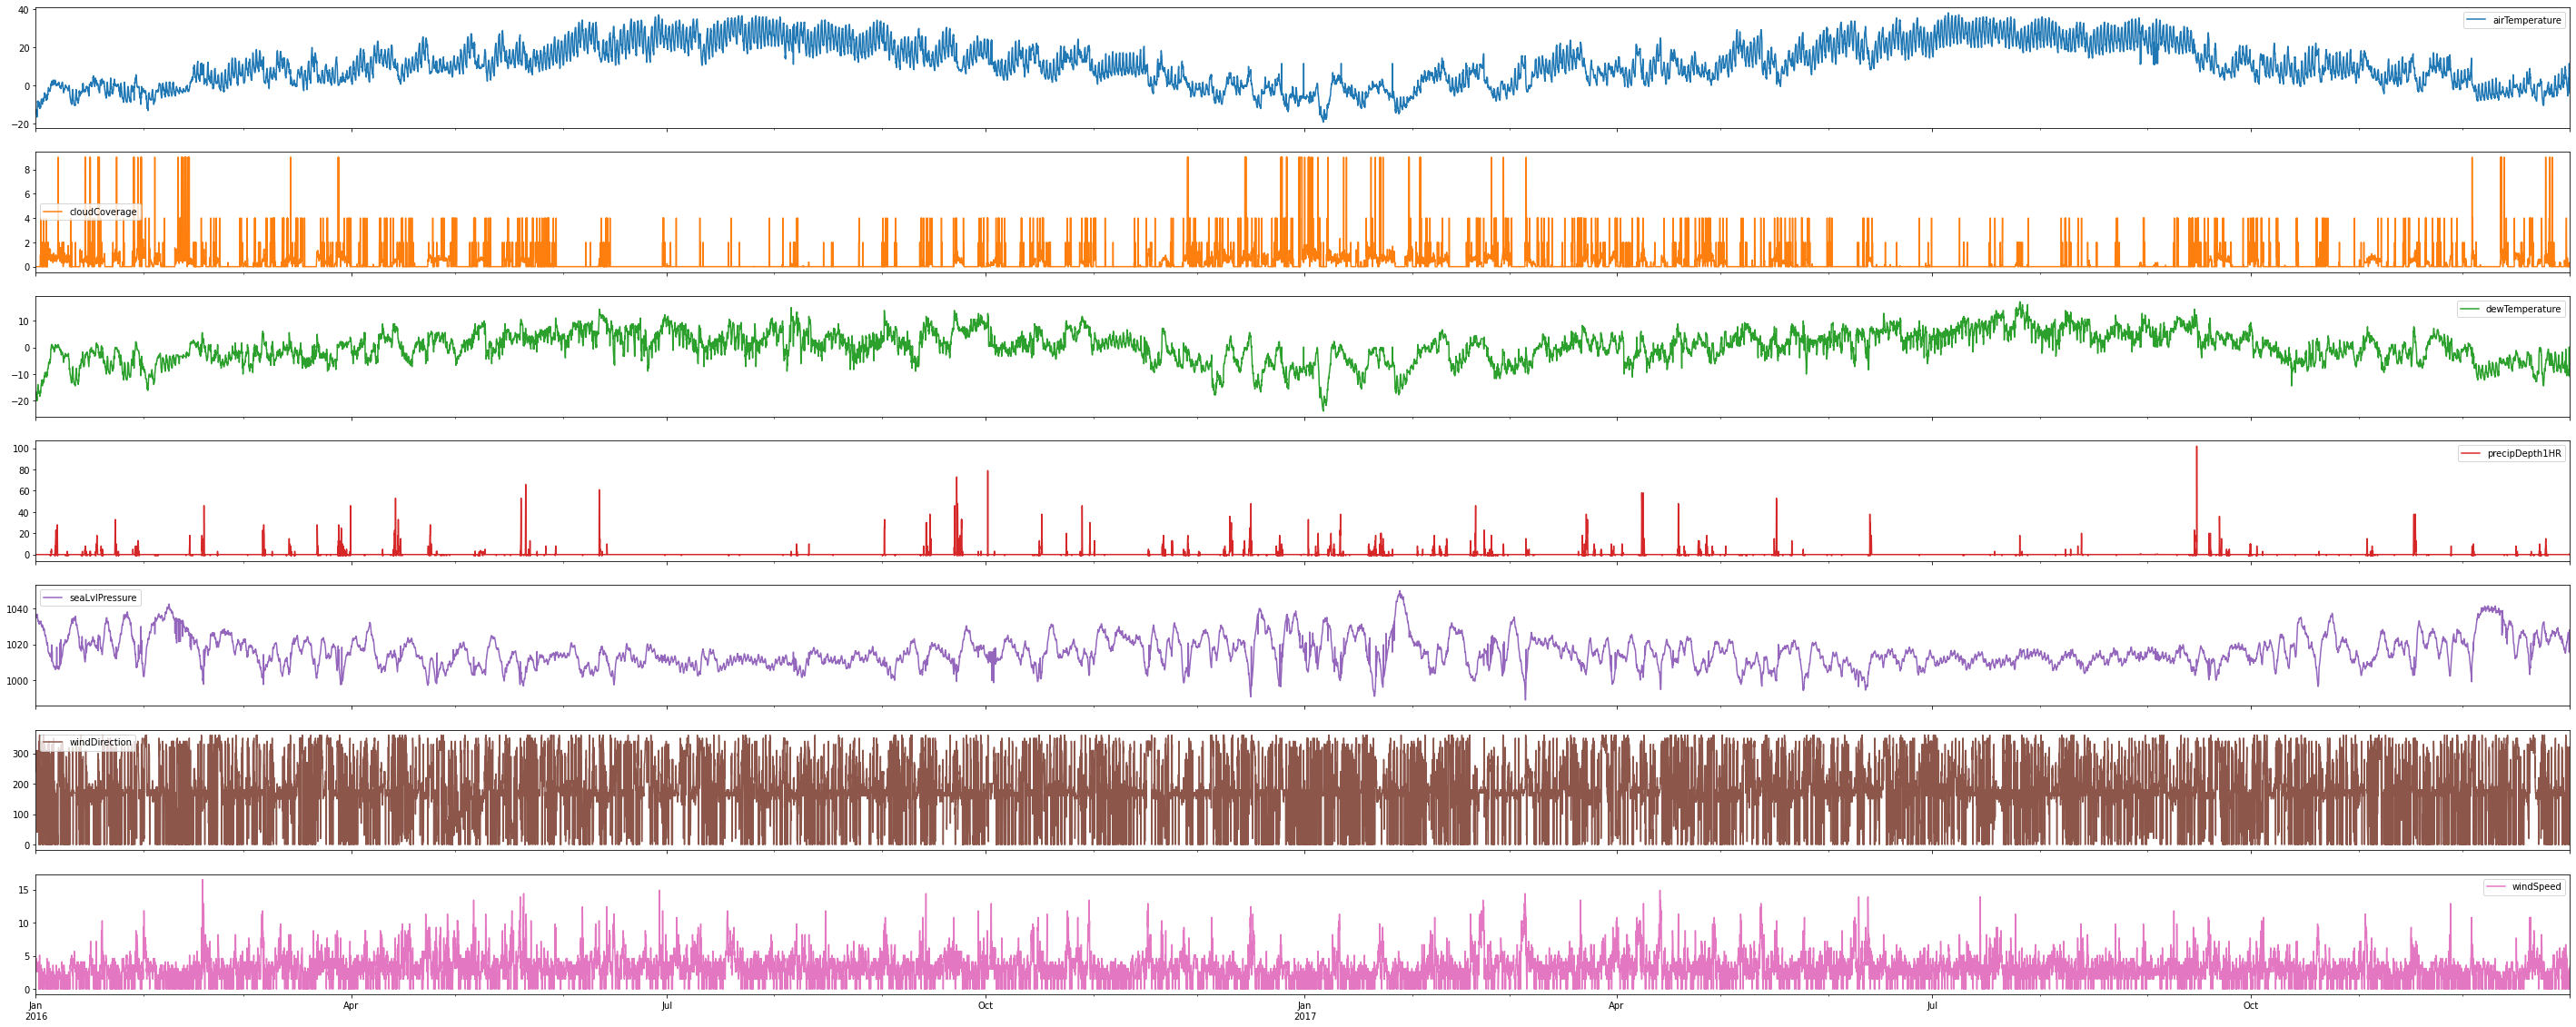

In [8]:
## Llenando los nulos con un KNNImputer
imputer = KNNImputer(n_neighbors=168)
original_index = df_weather_bobcat.index
df_weather_bobcat = pd.DataFrame(imputer.fit_transform(df_weather_bobcat), columns=df_weather_bobcat.columns)
df_weather_bobcat.index = original_index
for col in df_weather_bobcat.columns:    
    null_values.append(count_null_incol(df_weather_bobcat, col))
df_weather_bobcat.plot(subplots = True, figsize=(50, 20))

In [9]:
# Estudio de la metadata
df_metadata = pd.read_csv('metadata.csv')
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1636 entries, 0 to 1635
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   building_id            1636 non-null   object 
 1   site_id                1636 non-null   object 
 2   building_id_kaggle     1449 non-null   float64
 3   site_id_kaggle         1599 non-null   float64
 4   primaryspaceusage      1615 non-null   object 
 5   sub_primaryspaceusage  1615 non-null   object 
 6   sqm                    1636 non-null   float64
 7   sqft                   1636 non-null   float64
 8   lat                    1399 non-null   float64
 9   lng                    1399 non-null   float64
 10  timezone               1636 non-null   object 
 11  electricity            1578 non-null   object 
 12  hotwater               185 non-null    object 
 13  chilledwater           555 non-null    object 
 14  steam                  370 non-null    object 
 15  wate

In [11]:
# Estudio de los datos de los edificios

In [10]:
#Importamos todos los datos de los ediificios
df_gas = pd.read_csv('gas_cleaned.csv')
df_hotwater = pd.read_csv('hotwater_cleaned.csv')
df_irrigation = pd.read_csv('irrigation_cleaned.csv')
df_solar = pd.read_csv('solar_cleaned.csv')
df_steam = pd.read_csv('steam_cleaned.csv')
df_water = pd.read_csv('water_cleaned.csv')
df_electricity = pd.read_csv('electricity.csv')

In [11]:
#In this section we will take the column timestamp from all the dataframes and we will convert it to datetime format and set is as the index of the dataframe

df_gas['timestamp'] = pd.to_datetime(df_gas['timestamp'])
df_gas.set_index('timestamp', inplace=True, drop=True)

df_hotwater['timestamp'] = pd.to_datetime(df_hotwater['timestamp']) 
df_hotwater.set_index('timestamp', inplace=True, drop=True) 

df_irrigation['timestamp'] = pd.to_datetime(df_irrigation['timestamp'])
df_irrigation.set_index('timestamp', inplace=True, drop=True)   

df_solar['timestamp'] = pd.to_datetime(df_solar['timestamp'])       
df_solar.set_index('timestamp', inplace=True, drop=True)    

df_steam['timestamp'] = pd.to_datetime(df_steam['timestamp'])
df_steam.set_index('timestamp', inplace=True, drop=True)

df_water['timestamp'] = pd.to_datetime(df_water['timestamp'])   
df_water.set_index('timestamp', inplace=True, drop=True)    

df_electricity['timestamp'] = pd.to_datetime(df_electricity['timestamp'])
df_electricity.set_index('timestamp', inplace=True, drop=True)

In [12]:
#We create a list that contains all the dataframes
df_name_list = [df_gas, df_hotwater, df_irrigation, df_solar, df_steam, df_water, df_electricity]

In [12]:
### To reduce the number of buildings to study, we will only see those to which we haver solar information.

In [13]:
building_list = df_solar.columns.tolist()
del building_list[0]
print(building_list)
print(type(building_list))

['Bobcat_education_Alissa', 'Bobcat_education_Coleman', 'Bobcat_other_Timothy', 'Bobcat_office_Justine']
<class 'list'>


In [15]:
#We create a list that contains the dataframes of each building.
datasets = []
for building_id in building_list:
    datasets.append(extract_data(building_id, df_name_list))

In [16]:
#In this section of code we will drop all the columns that are all null or that are -1 in all the dataframes
for i in range(len(datasets)):
    datasets[i] = datasets[i].dropna(axis=1, how='all')
    datasets[i] = datasets[i].dropna(axis=0, how='all')
    datasets[i] = datasets[i].replace(-1, np.nan)
    datasets[i] = datasets[i].dropna(axis=1, how='all')
    datasets[i] = datasets[i].dropna(axis=0, how='all')
    datasets[i] = datasets[i].interpolate(method='linear', limit_direction='forward', axis=0)
    datasets[i] = datasets[i].interpolate(method='linear', limit_direction='backward', axis=0)
    datasets[i] = datasets[i].fillna(0)     

In [23]:
#In this section we will apply a knn imputer to fill the missing values of each dataset from the list of dataset datasets

imputer = KNNImputer(n_neighbors=168)
aux_df = pd.DataFrame()
new_df_list = []
for dataset in datasets:  
    originial_dataset_index = dataset.index
    aux_df = pd.DataFrame(imputer.fit_transform(dataset), columns=dataset.columns)
    aux_df.index = originial_dataset_index
    new_df_list.append(aux_df)
    print(aux_df.isnull().sum())
    

gas            0
hotwater       0
solar          0
electricity    0
dtype: int64
solar          0
water          0
electricity    0
dtype: int64
solar          0
water          0
electricity    0
dtype: int64
gas            0
water          0
electricity    0
dtype: int64


In [26]:
#Now that we have all the dataframes with the missing values filled we will merge every dataset from the list new_df_list with the weather dataframe df_weather_bobcat using the timestamp as the index
#We will do this by creating a list of dataframes that will contain the merged dataframes
merged_df_list = []
for i in range(len(new_df_list)):
    merged_df_list.append(df_weather_bobcat.merge(new_df_list[i], left_index=True, right_index=True, how='left'))
    print(merged_df_list[i].isnull().sum())
    

airTemperature     0
cloudCoverage      0
dewTemperature     0
precipDepth1HR     0
seaLvlPressure     0
windDirection      0
windSpeed          0
gas               16
hotwater          16
solar             16
electricity       16
dtype: int64
airTemperature     0
cloudCoverage      0
dewTemperature     0
precipDepth1HR     0
seaLvlPressure     0
windDirection      0
windSpeed          0
solar             20
water             20
electricity       20
dtype: int64
airTemperature     0
cloudCoverage      0
dewTemperature     0
precipDepth1HR     0
seaLvlPressure     0
windDirection      0
windSpeed          0
solar             19
water             19
electricity       19
dtype: int64
airTemperature     0
cloudCoverage      0
dewTemperature     0
precipDepth1HR     0
seaLvlPressure     0
windDirection      0
windSpeed          0
gas               21
water             21
electricity       21
dtype: int64


In [32]:
#If there is any null value in the merged dataframe we will fill it with using the knn imputer
for i in range(len(merged_df_list)):
    original_index = merged_df_list[i].index
    merged_df_list[i] = pd.DataFrame(imputer.fit_transform(merged_df_list[i]), columns=merged_df_list[i].columns)
    merged_df_list[i].index = original_index
    print(merged_df_list[i].isnull().sum())
datasets = merged_df_list.copy()

airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
gas               0
hotwater          0
solar             0
electricity       0
dtype: int64
airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
solar             0
water             0
electricity       0
dtype: int64
airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
solar             0
water             0
electricity       0
dtype: int64
airTemperature    0
cloudCoverage     0
dewTemperature    0
precipDepth1HR    0
seaLvlPressure    0
windDirection     0
windSpeed         0
gas               0
water             0
electricity       0
dtype: int64


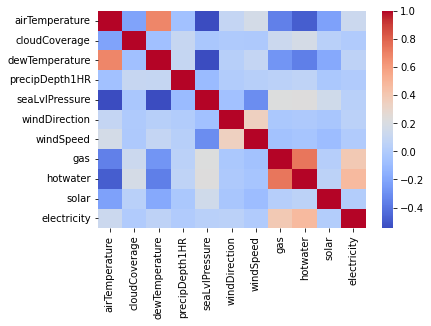

In [34]:
## We will create a corerlation heatmap of all the buildings that we have
# create a dictionary of dataframes with their names as keys
dfs = {'Bobcat_education_Dylan': datasets[0], 'Bobcat_education_Alissa': datasets[1], 'Bobcat_education_Coleman': datasets[2], 'Bobcat_other_Timothy': datasets[3]}

# create a dropdown menu with the dataframe names
dropdown = widgets.Dropdown(options=list(dfs.keys()))

# define a function to display the selected dataframe's correlation heatmap
def display_corr_heatmap(name):
    df = dfs.get(name)
    if df is not None:
        corr = df.corr()
        sns.heatmap(corr, cmap='coolwarm')
        plt.show()

# link the dropdown menu to the display function
widgets.interactive(display_corr_heatmap, name=dropdown)

In [35]:
df_timothy = datasets[3].copy()

airTemperature 
 cloudCoverage 
 dewTemperature 
 precipDepth1HR 
 seaLvlPressure 
 windDirection 
 windSpeed 
 gas 
 water 
 electricity 
 
 
 
 
 2016-01-01 00:00:00 
 -14.4 
 0.0 
 -16.7 
 0.0 
 1036.9 
 280.0 
 3.1 
 17.1786 
 0.0 
 20.62 
 
 
 2016-01-01 01:00:00 
 -13.3 
 0.0 
 -16.7 
 0.0 
 1036.0 
 240.0 
 3.1 
 25.7672 
 0.0 
 21.00 
 
 
 2016-01-01 02:00:00 
 -15.0 
 0.0 
 -17.8 
 0.0 
 1035.9 
 240.0 
 2.6 
 17.1778 
 0.0 
 20.50 
 
 
 2016-01-01 03:00:00 
 -12.8 
 0.0 
 -17.8 
 0.0 
 1035.0 
 310.0 
 2.6 
 17.1782 
 0.0 
 20.25 
 
 
 2016-01-01 04:00:00 
 -14.4 
 0.0 
 -18.3 
 0.0 
 1035.3 
 300.0 
 3.6 
 25.7672 
 0.0 
 20.25

## Analisis del Dataset 

In [36]:
print("La base de datos tiene una forma de",df_timothy.shape[0],"filas y", df_timothy.shape[1], "columnas")
df_timothy.head()

La base de datos tiene una forma de 17544 filas y 10 columnas


airTemperature 
 cloudCoverage 
 dewTemperature 
 precipDepth1HR 
 seaLvlPressure 
 windDirection 
 windSpeed 
 gas 
 water 
 electricity 
 
 
 
 
 2016-01-01 00:00:00 
 -14.4 
 0.0 
 -16.7 
 0.0 
 1036.9 
 280.0 
 3.1 
 17.1786 
 0.0 
 20.62 
 
 
 2016-01-01 01:00:00 
 -13.3 
 0.0 
 -16.7 
 0.0 
 1036.0 
 240.0 
 3.1 
 25.7672 
 0.0 
 21.00 
 
 
 2016-01-01 02:00:00 
 -15.0 
 0.0 
 -17.8 
 0.0 
 1035.9 
 240.0 
 2.6 
 17.1778 
 0.0 
 20.50 
 
 
 2016-01-01 03:00:00 
 -12.8 
 0.0 
 -17.8 
 0.0 
 1035.0 
 310.0 
 2.6 
 17.1782 
 0.0 
 20.25 
 
 
 2016-01-01 04:00:00 
 -14.4 
 0.0 
 -18.3 
 0.0 
 1035.3 
 300.0 
 3.6 
 25.7672 
 0.0 
 20.25

In [37]:
columns = df_timothy.columns
columns

Index(['airTemperature', 'cloudCoverage', 'dewTemperature', 'precipDepth1HR',
       'seaLvlPressure', 'windDirection', 'windSpeed', 'gas', 'water',
       'electricity'],
      dtype='object')

In [38]:
df_timothy.isnull().sum()

airTemperature 0
cloudCoverage 0
dewTemperature 0
precipDepth1HR 0
seaLvlPressure 0
windDirection 0
windSpeed 0
gas 0
water 0
electricity 0
dtype: int64

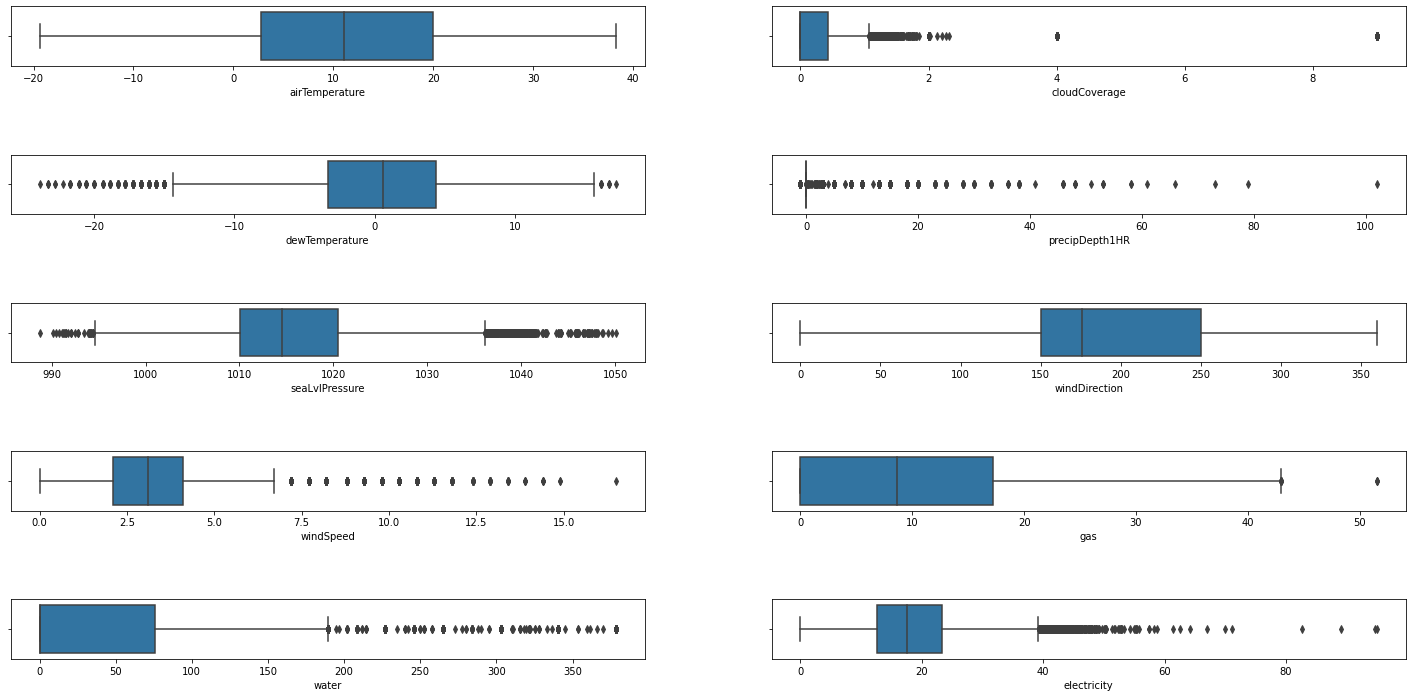

In [39]:
var = df_timothy.columns

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(25,12))
fig.subplots_adjust(hspace=1.5)

for i, var in enumerate(var):
  j = 0 if i%2==0 else 1
  sns.boxplot(x=var, data=df_timothy, ax=ax[i//2,j])

In [40]:
def calculate_outlier_representativity(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers_count = len(column[(column < lower_limit) | (column > upper_limit)])

    outliers_representativity = outliers_count / len(column) * 100

    return outliers_representativity



for column in df_timothy.columns:
    representativity = calculate_outlier_representativity(df_timothy[column])
    print(f"La representatividad de los valores atípicos en la columna {column} es del {representativity}%")

La representatividad de los valores atípicos en la columna airTemperature es del 0.0%
La representatividad de los valores atípicos en la columna cloudCoverage es del 9.176926584587324%
La representatividad de los valores atípicos en la columna dewTemperature es del 1.0544915640674875%
La representatividad de los valores atípicos en la columna precipDepth1HR es del 10.459416324669403%
La representatividad de los valores atípicos en la columna seaLvlPressure es del 2.3369813041495666%
La representatividad de los valores atípicos en la columna windDirection es del 0.0%
La representatividad de los valores atípicos en la columna windSpeed es del 4.736662106703146%
La representatividad de los valores atípicos en la columna gas es del 0.05699954400364797%
La representatividad de los valores atípicos en la columna water es del 8.299133606931145%
La representatividad de los valores atípicos en la columna electricity es del 2.5877792977656178%


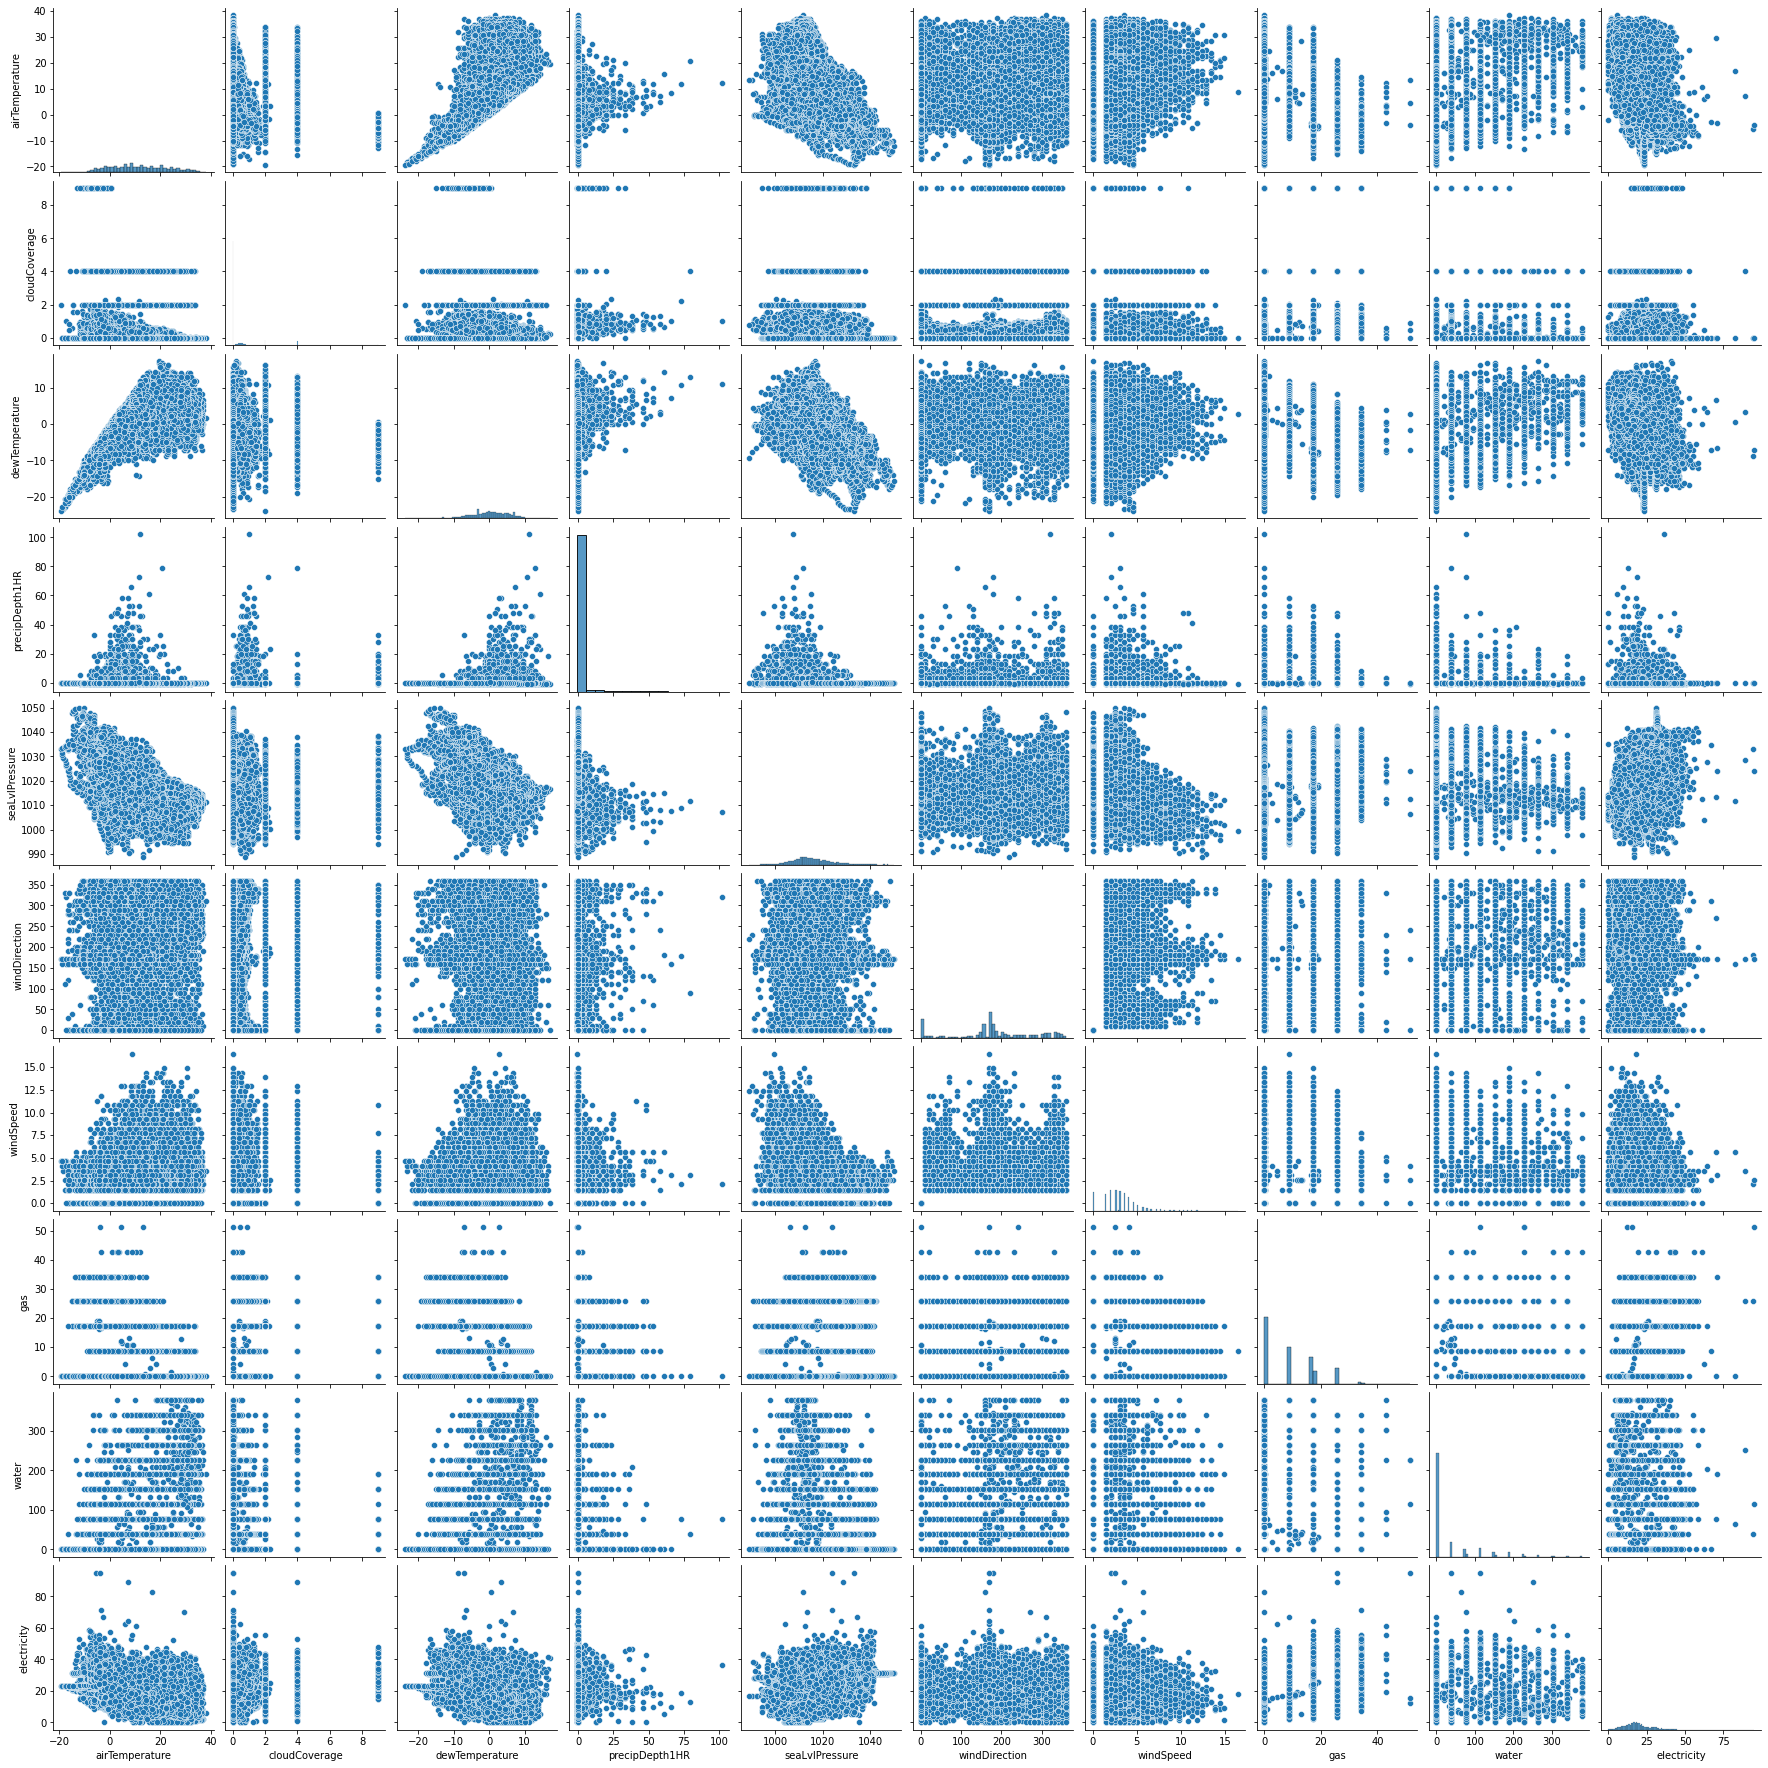

In [41]:
sns.pairplot(df_timothy)

plt.show()

In [28]:
'''corr = df_timothy#.drop(['timestamp'], axis=1).corr()

fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr, annot=True, ax=ax)
plt.title("Correlation Matrix Heatmap")
plt.show()'''

'corr = df_timothy#.drop([\'timestamp\'], axis=1).corr()\n\nfig, ax = plt.subplots(figsize=(15,15))\nsns.heatmap(corr, annot=True, ax=ax)\nplt.title("Correlation Matrix Heatmap")\nplt.show()'

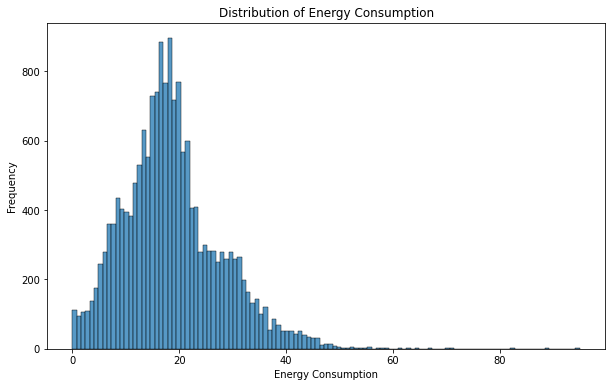

In [43]:

plt.figure(figsize=(10, 6))
sns.histplot(df_timothy['electricity'])
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')
plt.show()

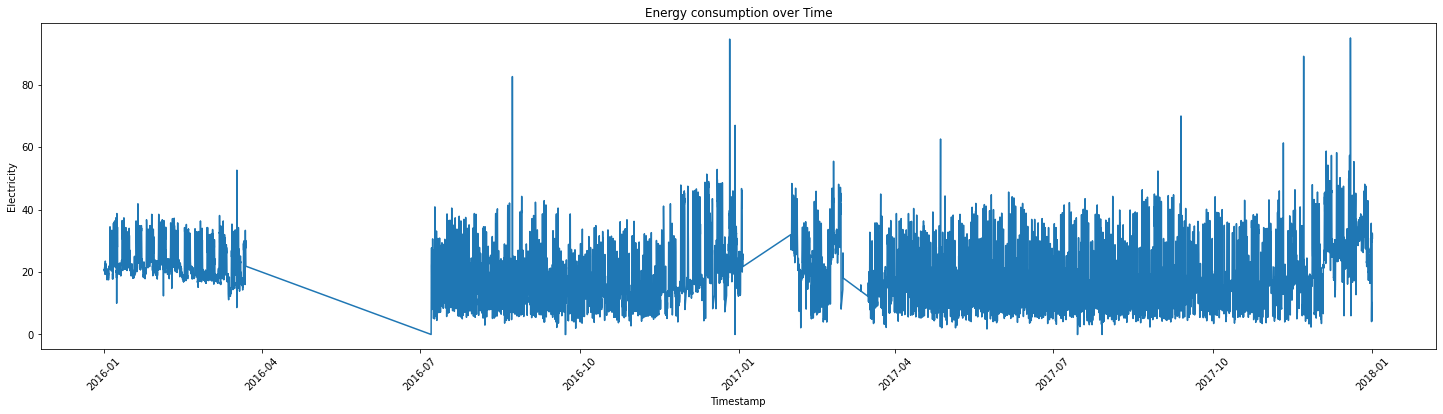

In [44]:
plt.figure(figsize=(25, 6))
plt.plot(df_timothy.index, df_timothy['electricity'])
plt.xlabel('Timestamp')
plt.ylabel('Electricity')
plt.title('Energy consumption over Time')

# Rotar las etiquetas del eje x para mayor claridad (opcional)
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

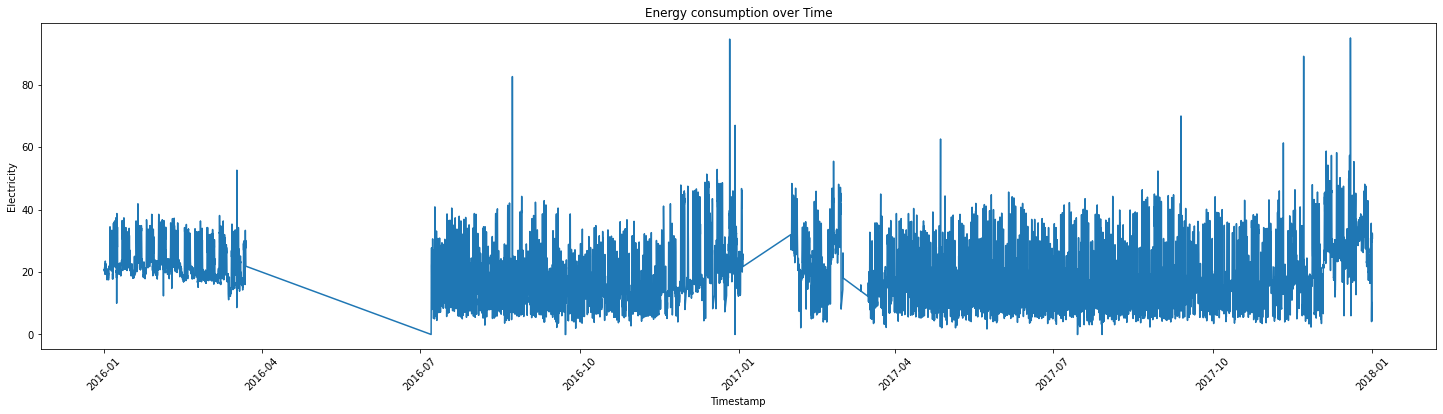

In [45]:
plt.figure(figsize=(25, 6))
plt.plot(df_timothy.index, df_timothy['electricity'])
plt.xlabel('Timestamp')
plt.ylabel('Electricity')
plt.title('Energy consumption over Time')

# Rotar las etiquetas del eje x para mayor claridad (opcional)
plt.xticks(rotation=45)

# Mostrar la gráfica
plt.show()

In [46]:
col_i = ['solar', 'water', 'airTemperature',
       'cloudCoverage', 'dewTemperature', 'precipDepth1HR', 'seaLvlPressure',
       'windDirection', 'windSpeed']

def plotsb(data, var):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    fig.subplots_adjust(hspace=1.5)
    
# Gráfico de dispersión
    ax1.scatter(data[var], data['electricity'])
    ax1.set_xlabel(var)
    ax1.set_ylabel('Energy Consumption')
    ax1.set_title('Scatter Plot: Energy Consumption vs {}'.format(var))

# Diagrama de caja
    ax2.boxplot(data[var].dropna())
    ax2.set_ylabel('Electricity')
    ax2.set_title('Box Plot: {}'.format(var))

# Mostrar los subplots
    plt.show()


In [47]:

def times(data, var): 
    # Crear la gráfica

    plt.figure(figsize=(25, 6))
    plt.plot(data.index, data[var])
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.title('{} over Time'.format(var))

# Rotar las etiquetas del eje x para mayor claridad (opcional)
    plt.xticks(rotation=45)

# Mostrar la gráfica
    plt.show()


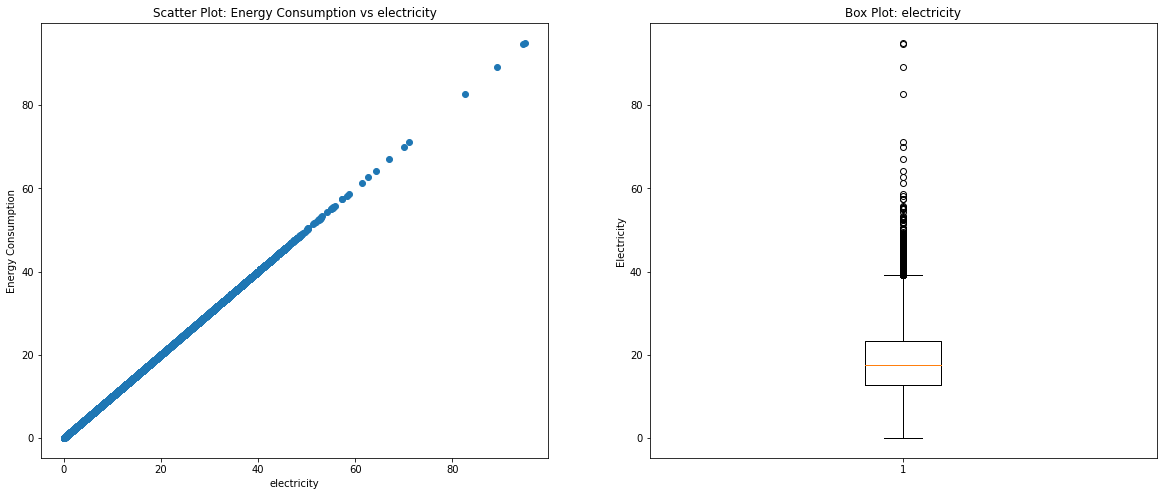

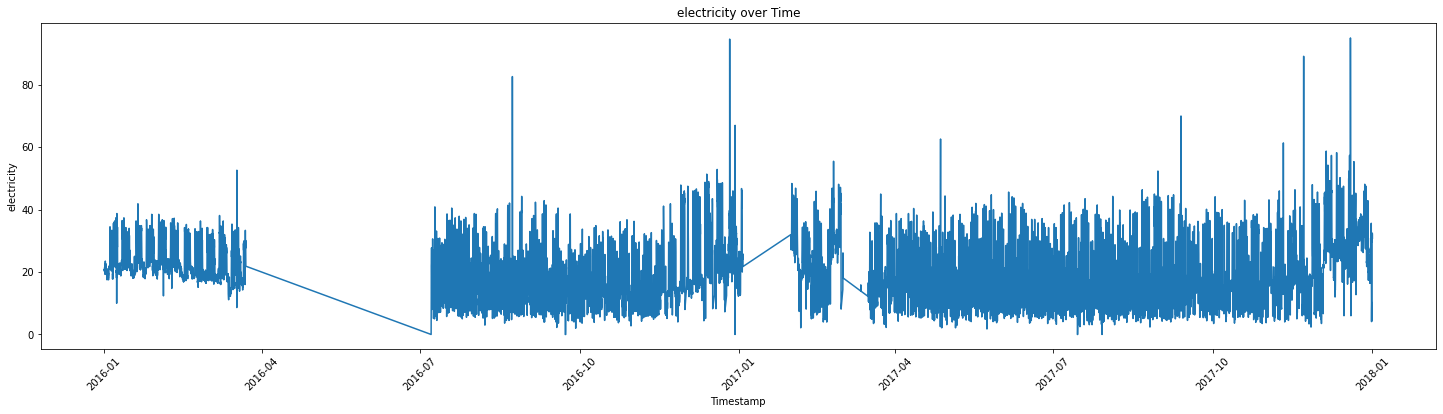

In [48]:

plotsb(df_timothy, 'electricity')
times(df_timothy, 'electricity')
# plorsb(df_t, 'gas')
# times(df_t, 'gas')
# plorsb(df_t, 'hotwater')
# times(df_timothy, 'hotwater')

KeyError: KeyError: 'solar'

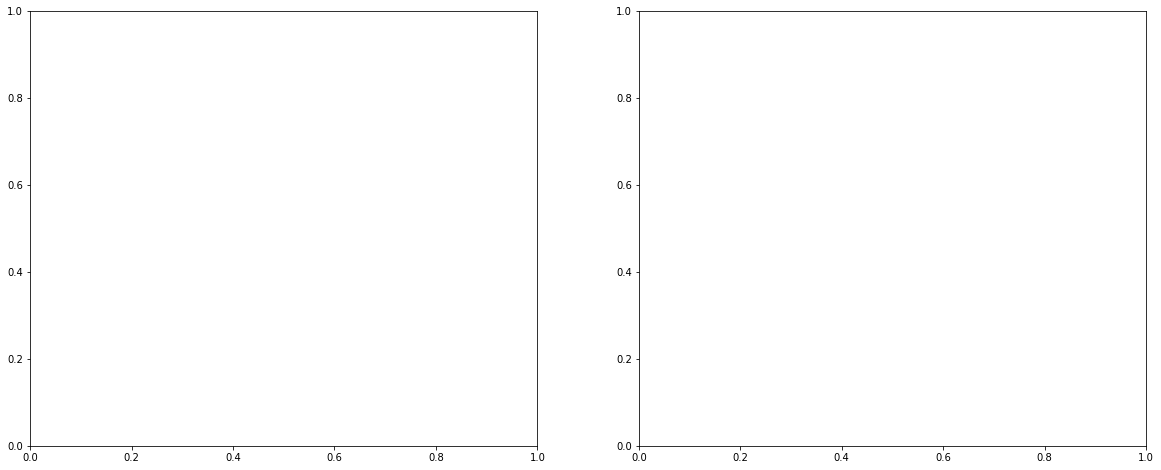

In [34]:

plotsb(df_timothy, 'solar')
times(df_timothy, 'solar')
# plorsb(df_t, 'chilledwater')
# times(df_t, 'chilledwater')

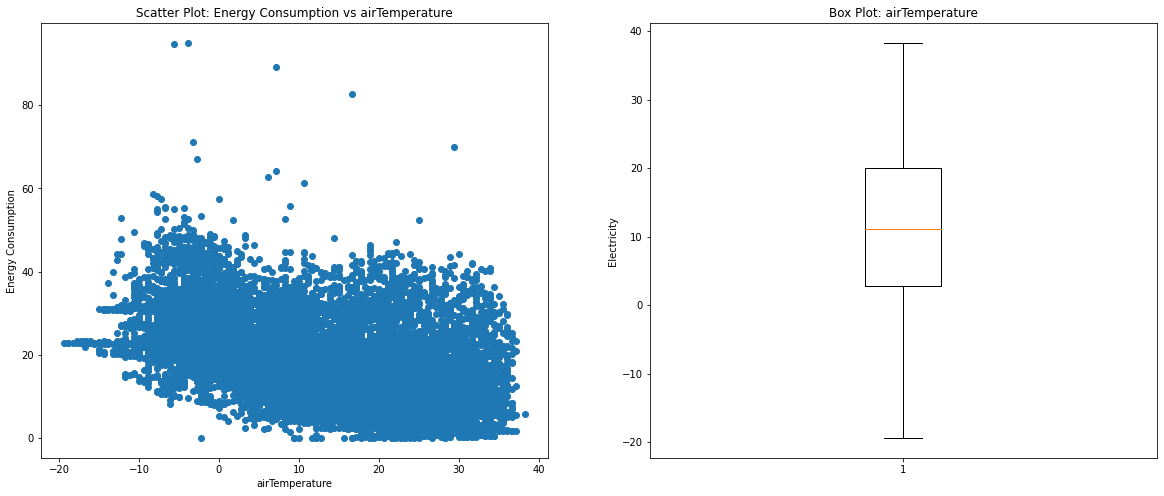

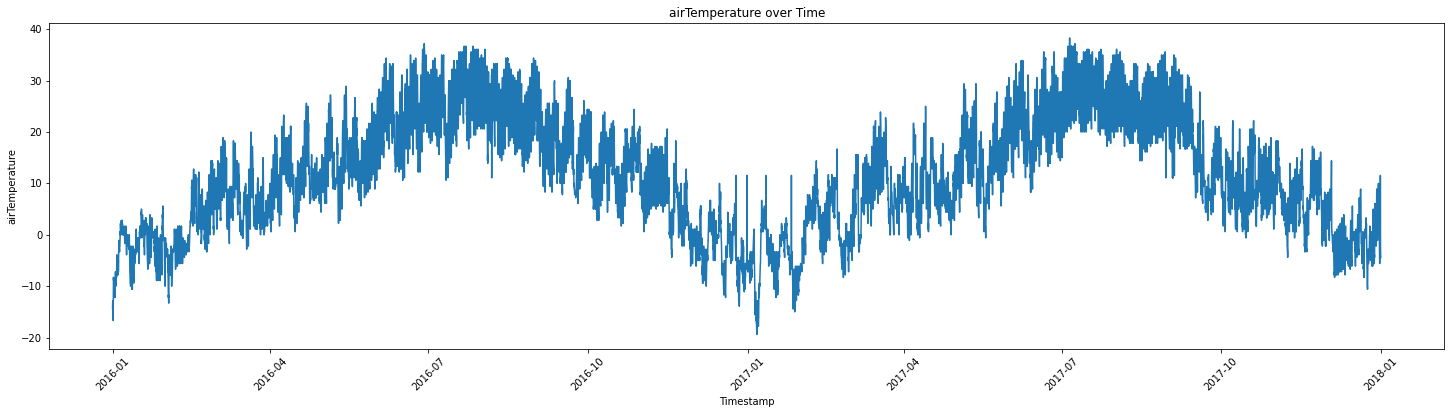

In [49]:

plotsb(df_timothy, 'airTemperature')
times(df_timothy, 'airTemperature')

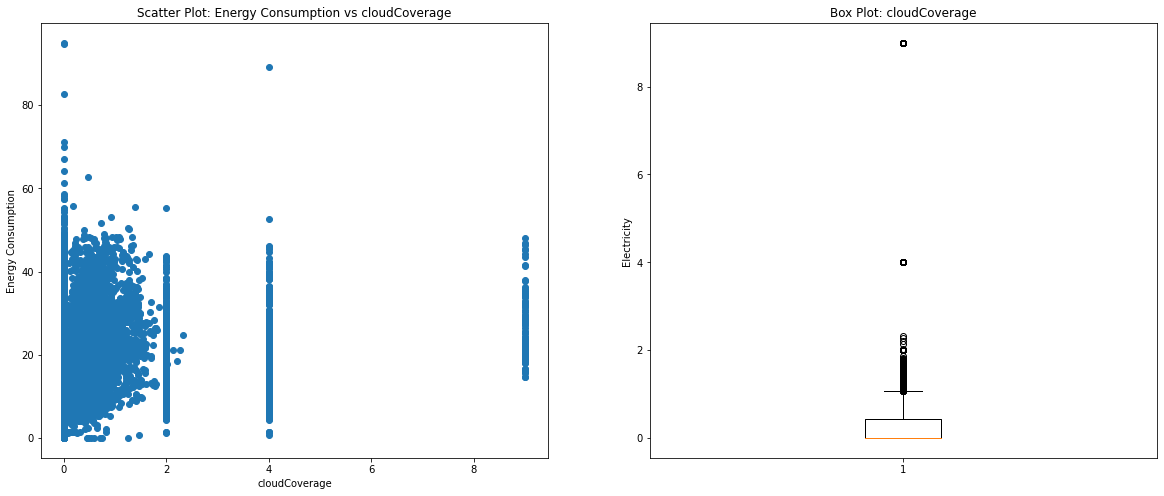

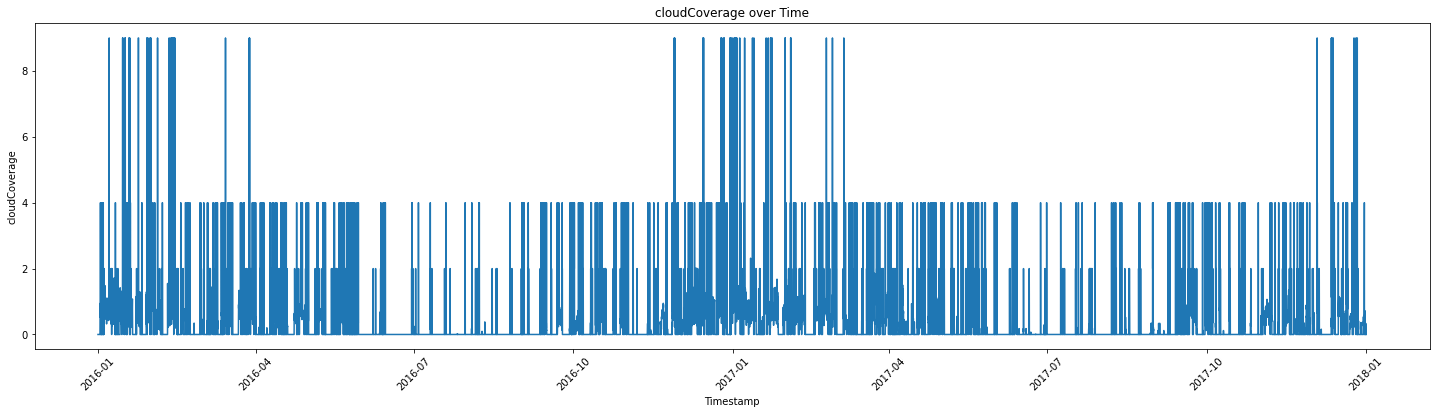

In [50]:

plotsb(df_timothy, 'cloudCoverage')
times(df_timothy, 'cloudCoverage')

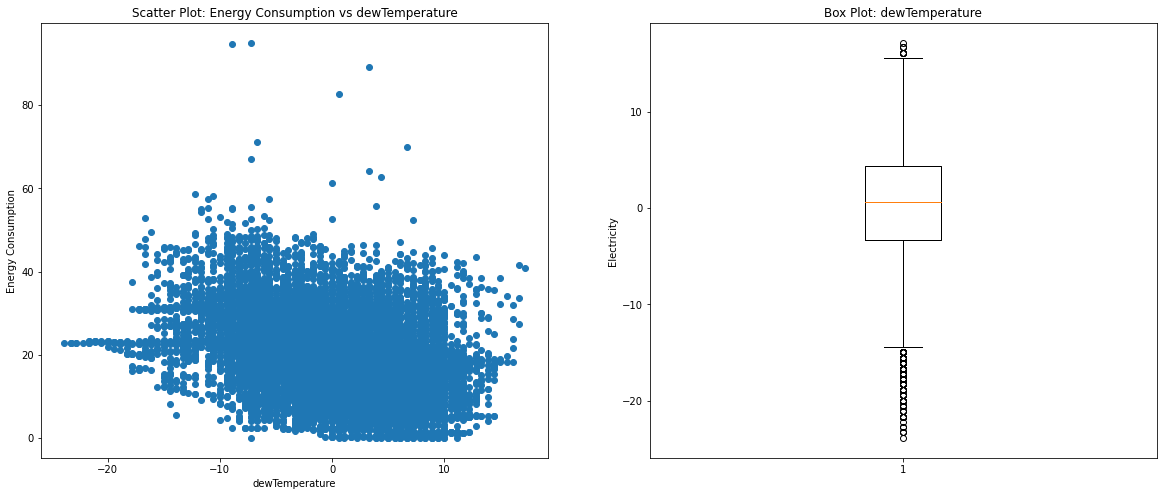

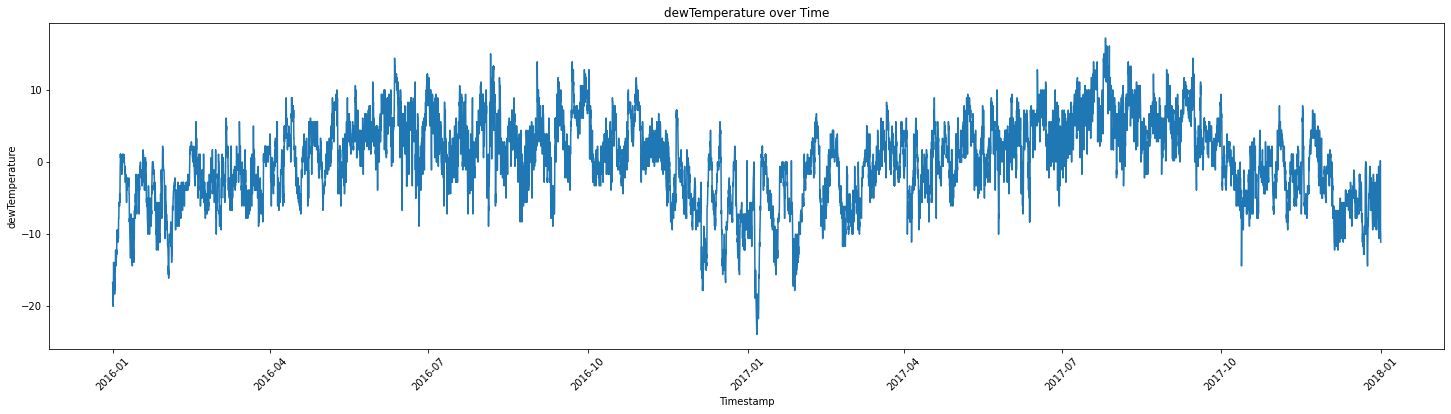

In [51]:

plotsb(df_timothy, 'dewTemperature')
times(df_timothy, 'dewTemperature')

In [52]:
### Analsis de Varianza 

def covdata(datos, var): 
    # Cargar los datos de la serie temporal en un DataFrame de Pandas
    data = datos[var]
    
    # Calcular la media de la serie
    means = float(data.mean())

# Calcular la desviación estándar de la serie
    std = float(data.std())

# Calcular la varianza de la serie
    variance = std ** 2
    print(variance)

# Crear una figura y un eje para trazar la serie temporal
    fig, ax = plt.subplots(figsize= (15,4))

# Trazar la serie temporal y la media
    ax.plot(datos.index, data, label='Serie temporal')
    ax.axhline(means, color='r', label='Media')

# Trazar dos veces la desviación estándar por encima y por debajo de la media
    ax.axhline(means + 2 * std, linestyle='--', color='g', label='2 * Desviación estándar')
    ax.axhline(means - 2 * std, linestyle='--', color='g')

# Configurar las etiquetas del eje x
    ax.tick_params(axis='x', rotation=45)

# Agregar leyenda y título
    ax.legend()
    ax.set_title('Serie temporal {} con media y dos veces la desviación estándar'.format(var))

    plt.show()

82.47211752955181


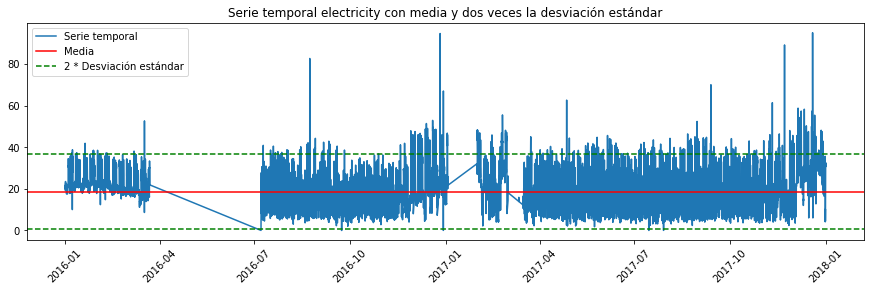

In [53]:

covdata(df_timothy, 'electricity')
# covdata(df2, 'gas')
#covdata(df2, 'hotwater')

In [54]:

covdata(df_timothy, 'solar')
#covdata(df2, 'chilledwater')

KeyError: KeyError: 'solar'

127.32738172891739


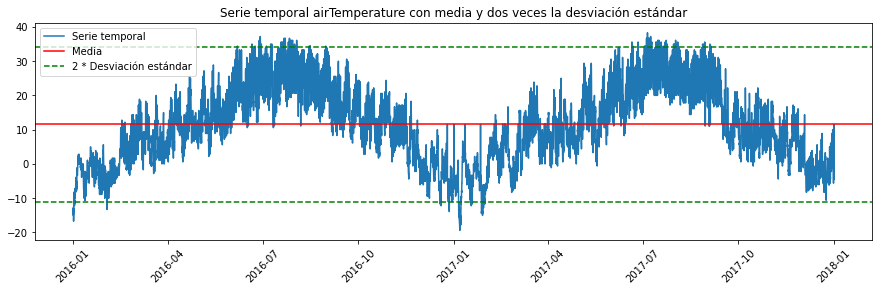

In [55]:

covdata(df_timothy, 'airTemperature')

1.127706664185475


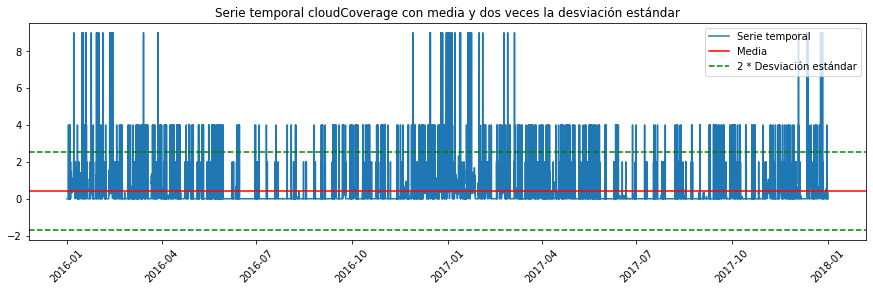

In [56]:

covdata(df_timothy, 'cloudCoverage')

32.572205645992256


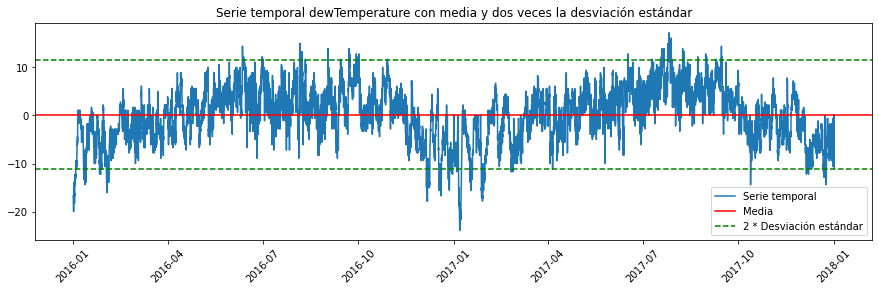

In [57]:

covdata(df_timothy, 'dewTemperature')

10.130101899394017


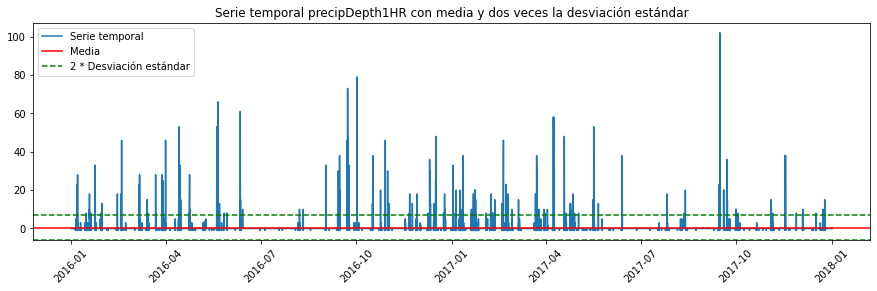

In [58]:

covdata(df_timothy, 'precipDepth1HR')

71.4907464398206


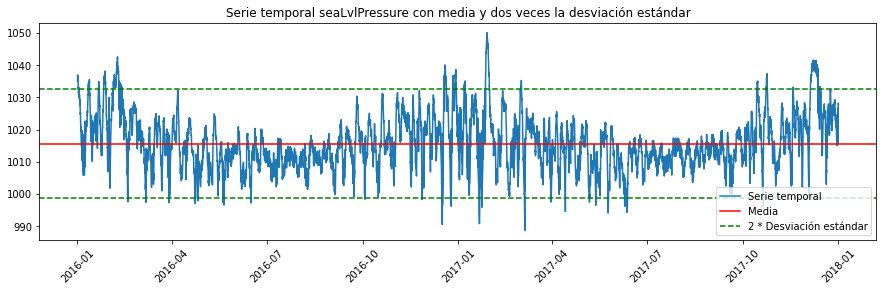

In [59]:

covdata(df_timothy, 'seaLvlPressure')

9900.991868528494


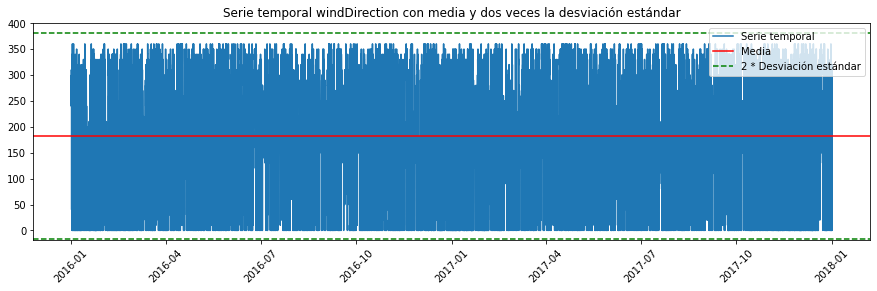

In [60]:

covdata(df_timothy, 'windDirection')

4.107060958051759


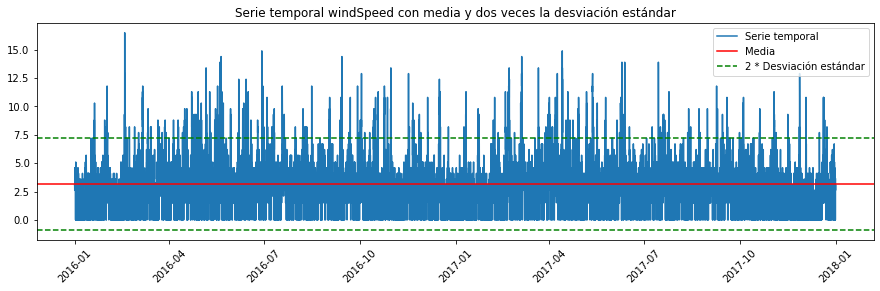

In [61]:

covdata(df_timothy, 'windSpeed')

### Descomposicion de la serie temporal 

In [62]:
df_timothy.head()

airTemperature 
 cloudCoverage 
 dewTemperature 
 precipDepth1HR 
 seaLvlPressure 
 windDirection 
 windSpeed 
 gas 
 water 
 electricity 
 
 
 
 
 2016-01-01 00:00:00 
 -14.4 
 0.0 
 -16.7 
 0.0 
 1036.9 
 280.0 
 3.1 
 17.1786 
 0.0 
 20.62 
 
 
 2016-01-01 01:00:00 
 -13.3 
 0.0 
 -16.7 
 0.0 
 1036.0 
 240.0 
 3.1 
 25.7672 
 0.0 
 21.00 
 
 
 2016-01-01 02:00:00 
 -15.0 
 0.0 
 -17.8 
 0.0 
 1035.9 
 240.0 
 2.6 
 17.1778 
 0.0 
 20.50 
 
 
 2016-01-01 03:00:00 
 -12.8 
 0.0 
 -17.8 
 0.0 
 1035.0 
 310.0 
 2.6 
 17.1782 
 0.0 
 20.25 
 
 
 2016-01-01 04:00:00 
 -14.4 
 0.0 
 -18.3 
 0.0 
 1035.3 
 300.0 
 3.6 
 25.7672 
 0.0 
 20.25

In [34]:
df_timothy.index

RangeIndex(start=0, stop=17544, step=1)

In [66]:

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
#from matplotlib.widgets import Zoom
'''
def desser(var):
    data = pd.DataFrame()

    # Crear valores de timestamp con frecuencia horaria
    start_date = df_timothy['timestamp'].min()  # Fecha de inicio
    end_date = df_timothy['timestamp'].max()  # Fecha de fin
    timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

    # Asignar valores de timestamp al DataFrame
    data['timestamp'] = timestamps

    data[var] = 0
    data[var] = df_timothy[var]

    data = data.set_index('timestamp')

    # Aplicar interpolación para llenar valores faltantes
    data[var] = data[var].interpolate()

    # Eliminar filas con valores faltantes
    data = data.dropna()

    # Realizar la descomposición estacional de manera aditiva
    SerieDescompuesta = seasonal_decompose(data[var], model='additive')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 12))  # Ancho: 20 pulgadas, Alto: 12 pulgadas

    # Graficar la descomposición de la serie temporal
    SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

    # Habilitar zoom en el gráfico
    zoom = Zoom(plt.gca())

    # Agregar el widget de zoom al gráfico
    plt.gca().figure.canvas.mpl_connect('scroll_event', zoom.on_scroll)
    plt.gca().figure.canvas.mpl_connect('button_press_event', zoom.on_press)
    plt.gca().figure.canvas.mpl_connect('button_release_event', zoom.on_release)

    # Mostrar el gráfico
    plt.show()'''

import matplotlib.pyplot as plt
'''
def desser(var):
    data = pd.DataFrame()

    # Crear valores de timestamp con frecuencia horaria
    start_date = df_timothy.index.min()  # Fecha de inicio
    end_date = df_timothy.index.max()  # Fecha de fin
    timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

    # Asignar valores de timestamp al DataFrame
    data.index = timestamps

    data[var] = 0
    data[var] = df_timothy[var]

    data = data.set_index('timestamp')

    # Aplicar interpolación para llenar valores faltantes
    data[var] = data[var].interpolate()

    # Eliminar filas con valores faltantes
    data = data.dropna()

    # Realizar la descomposición estacional de manera aditiva
    SerieDescompuesta = seasonal_decompose(data[var], model='additive')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 12))  # Ancho: 20 pulgadas, Alto: 12 pulgadas

    # Graficar la descomposición de la serie temporal
    SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

    # Ajustar límites del eje para permitir el efecto de zoom
    plt.axis('zoomed_in')

    # Mostrar el gráfico
    plt.show()'''

In [73]:
def desser(var, df_2):
    # data = pd.DataFrame()
    

    # Crear valores de timestamp con frecuencia horaria
    #start_date = var.index.min()  # Fecha de inicio
    #end_date = var.index.max()  # Fecha de fin
    #timestamps = pd.date_range(start=start_date, end=end_date, freq='H')

    # # Asignar valores de timestamp al DataFrame
    # data['timestamp'] = df_2.index

    # data[var]= 0
    # data[var] = df_2[var]

    # data = data.set_index('timestamp')

    # # Aplicar interpolación para llenar valores faltantes
    # data[var] = data[var].interpolate()

    # # Eliminar filas con valores faltantes
    # data = data.dropna()

    # Realizar la descomposición estacional de manera aditiva
    SerieDescompuesta = seasonal_decompose(df_2[var], model='additive')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 12))  # Ancho: 20 pulgadas, Alto: 12 pulgadas

    # Graficar la descomposición de la serie temporal
    SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

    # Mostrar el gráfico
    plt.show()

In [86]:
!pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.0/89.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for mplcursors: filename=mplcursors-0.5.2-py3-none-any.whl size=21054 sha256=439fa5c06208b72868d5b6ab458f081c3d173334b61bfed373a8202a37ee3515
  Stored in directory: /home/datalore/.cache/pip/wheels/6d/02/b1/7d5c397daf88f75d3432168edddd8b02d3ae2c050ffa7ca26f
Successfully built mplcursors


In [87]:
import matplotlib.pyplot as plt
import mplcursors

def desser(var, df_2):
    # Realizar la descomposición estacional de manera aditiva
    SerieDescompuesta = seasonal_decompose(df_2[var], model='additive')

    # Configurar el tamaño de la figura
    plt.figure(figsize=(20, 12))  # Ancho: 20 pulgadas, Alto: 12 pulgadas

    # Graficar la descomposición de la serie temporal
    SerieDescompuesta.plot(observed=True, seasonal=True, trend=True, resid=True, weights=False)

    # Habilitar el zoom en el gráfico
    mplcursors.cursor(hover=True).connect("add", lambda sel: sel.annotation.set_text(sel.artist.get_label()))

    # Mostrar el gráfico
    plt.show()

<Figure size 1440x864 with 0 Axes>

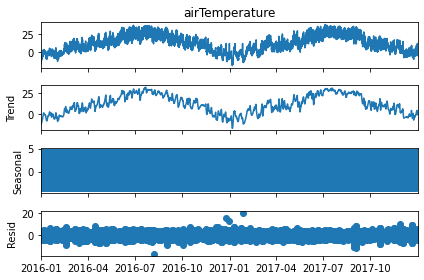

<Figure size 1440x864 with 0 Axes>

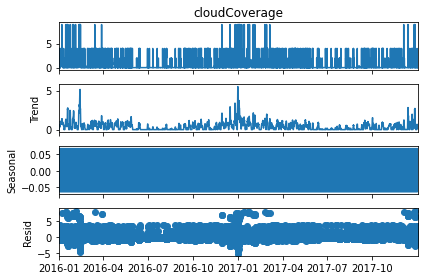

<Figure size 1440x864 with 0 Axes>

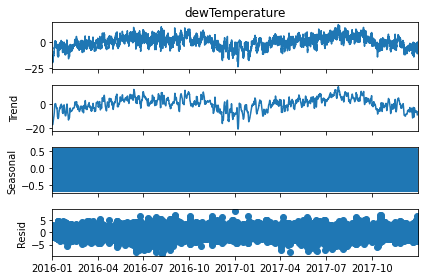

<Figure size 1440x864 with 0 Axes>

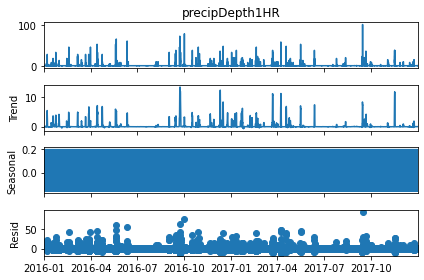

<Figure size 1440x864 with 0 Axes>

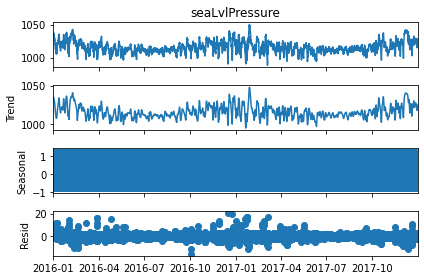

<Figure size 1440x864 with 0 Axes>

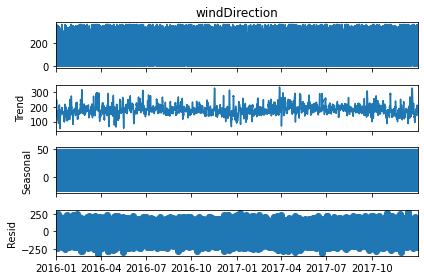

<Figure size 1440x864 with 0 Axes>

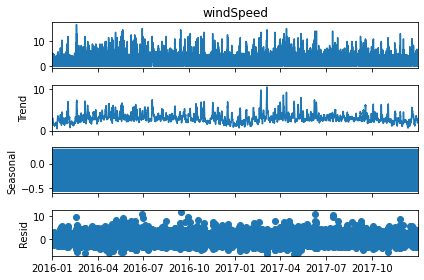

<Figure size 1440x864 with 0 Axes>

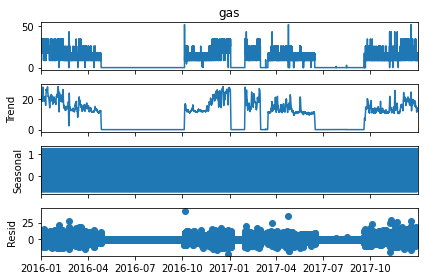

<Figure size 1440x864 with 0 Axes>

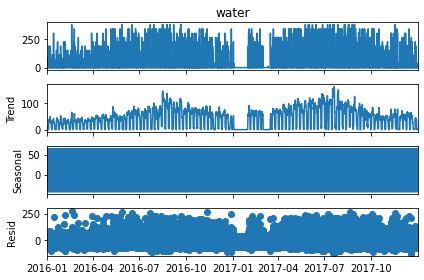

<Figure size 1440x864 with 0 Axes>

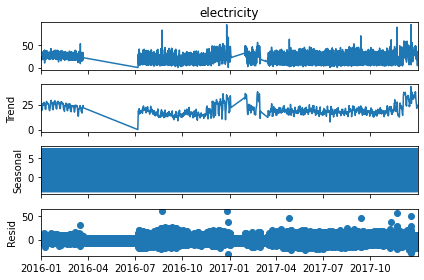

In [88]:
for i in df_timothy.columns:
    desser(i,df_timothy)

In [70]:
df_timothy.head()

airTemperature 
 cloudCoverage 
 dewTemperature 
 precipDepth1HR 
 seaLvlPressure 
 windDirection 
 windSpeed 
 gas 
 water 
 electricity 
 
 
 
 
 2016-01-01 00:00:00 
 -14.4 
 0.0 
 -16.7 
 0.0 
 1036.9 
 280.0 
 3.1 
 17.1786 
 0.0 
 20.62 
 
 
 2016-01-01 01:00:00 
 -13.3 
 0.0 
 -16.7 
 0.0 
 1036.0 
 240.0 
 3.1 
 25.7672 
 0.0 
 21.00 
 
 
 2016-01-01 02:00:00 
 -15.0 
 0.0 
 -17.8 
 0.0 
 1035.9 
 240.0 
 2.6 
 17.1778 
 0.0 
 20.50 
 
 
 2016-01-01 03:00:00 
 -12.8 
 0.0 
 -17.8 
 0.0 
 1035.0 
 310.0 
 2.6 
 17.1782 
 0.0 
 20.25 
 
 
 2016-01-01 04:00:00 
 -14.4 
 0.0 
 -18.3 
 0.0 
 1035.3 
 300.0 
 3.6 
 25.7672 
 0.0 
 20.25

In [ ]:
#Vamos a crear una funcion que nos permita hacer zoom a una grafica x, y
''' def plot_predictions_zoom(x, y, zoom_start, zoom_end):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label='Actual')
    plt.title('Electricity Demand Prediction')
    plt.xlabel('Time (hours)')
    plt.ylabel('Electricity Demand (MW)')
    plt.legend()
    plt.xlim(zoom_start, zoom_end)
    plt.show()'''

In [ ]:
for columna in columnas:
    # Crear una nueva figura para cada histograma
    plt.figure()
    
    # Crear el histograma de la columna actual
    plt.hist(df_timothy[columna], bins=10)
    
    # Agregar título y etiquetas a los ejes
    plt.title('Histograma de {}'.format(columna))
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    
    # Mostrar el histograma
    plt.show()

### Modelo Provisional 

#### Preparacion de los Datos para RN

In [76]:
dfexp = df_timothy.copy()

In [78]:
features = dfexp[['gas', 'airTemperature', 'cloudCoverage',
       'dewTemperature', 'precipDepth1HR', 'seaLvlPressure', 'windDirection',
       'windSpeed']]

target = dfexp[['electricity']]

In [80]:
def f_scaler(df):
    scalers = {}
    df_scaled = pd.DataFrame()
    for column in df.columns:
        scaler = MinMaxScaler()
        column_scaled = scaler.fit_transform(df[[column]])
        df_scaled[column] = column_scaled.flatten()
        scalers[column] = scaler
        
    return scalers, df_scaled

train_set = df_timothy.loc[:'2017-06-30 23:00:00']
train_scaler, train_data = f_scaler(train_set)

test_set  = df_timothy.loc['2017-07-01 00:00:00':]
test_scaler, test_data = f_scaler(test_set)

In [81]:
X_train, y_train = [], []

for i in range(24, len(train_data)):
    X_train.append(train_data[i-24:i])
    y_train.append(train_data.iloc[i, -1])
X_train, y_train = np.array(X_train), np.array(y_train)


X_test, y_test = [], []

for i in range(24, len(test_data)):
    X_test.append(test_data[i-24:i])
    y_test.append(test_data.iloc[i, -1])
X_test, y_test = np.array(X_test), np.array(y_test)

In [90]:
import tensorflow as tf

win_length = 1
batch_size = 32
num_features = 9


model = tf.keras.Sequential()

model.add(tf.keras.layers.LSTM(75, input_shape= (X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(1))

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 24, 75)            25800     
                                                                 
 lstm_3 (LSTM)               (None, 50)                25200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 51,051
Trainable params: 51,051
Non-trainable params: 0
_________________________________________________________________


In [92]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience= 10,
                                                  mode = 'min')

model.compile(loss=tf.losses.MeanSquaredError(), 
              optimizer=tf.optimizers.Adam(), 
              metrics=[tf.metrics.MeanAbsoluteError()])


history = model.fit(X_train, y_train, epochs= 50,
                              validation_data= (X_test, y_test),
                              shuffle= False,
                              callbacks = [early_stopping])


Epoch 6/50
410/410 [==============================] - 10s 25ms/step - loss: 0.0019 - mean_absolute_error: 0.0271 - val_loss: 0.0031 - val_mean_absolute_error: 0.0389
Epoch 7/50
410/410 [==============================] - 10s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.0267 - val_loss: 0.0030 - val_mean_absolute_error: 0.0383
Epoch 8/50
410/410 [==============================] - 10s 24ms/step - loss: 0.0018 - mean_absolute_error: 0.0264 - val_loss: 0.0030 - val_mean_absolute_error: 0.0382
Epoch 9/50
410/410 [==============================] - 11s 26ms/step - loss: 0.0017 - mean_absolute_error: 0.0261 - val_loss: 0.0029 - val_mean_absolute_error: 0.0378
Epoch 10/50
410/410 [==============================] - 10s 25ms/step - loss: 0.0017 - mean_absolute_error: 0.0259 - val_loss: 0.0029 - val_mean_absolute_error: 0.0376
Epoch 11/50
410/410 [==============================] - 10s 25ms/step - loss: 0.0017 - mean_absolute_error: 0.0257 - val_loss: 0.0028 - val_mean_absolute_error: 0.0369
Ep

In [93]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

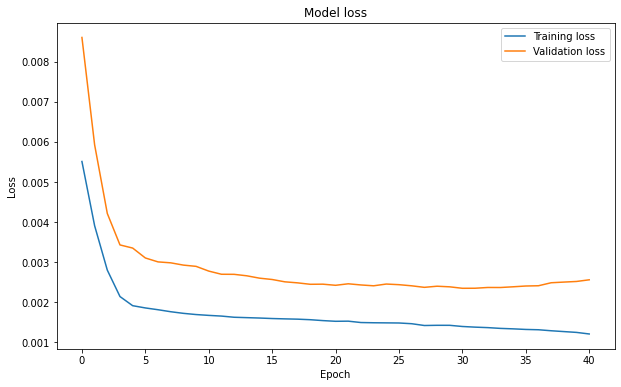

In [94]:
plot_loss(history)